In [1]:
import sympy as sm
import numpy as np

sm.init_printing()
%matplotlib notebook

## Equations of Motion

### System Setup

$l$ is the length of the car body, $a$ is the distance from the rear of the car body to its center of mass.

In [2]:
# inertias
mR, mF, mC, IC = sm.symbols('m_R m_F m_C I_C', real=True, positive=True)
# tire/suspension params
kT, cT, ksR, csR, ksF, csF = sm.symbols('k_T c_T k_{sR} c_{sR} k_{sF} c_{sF}', real=True, positive=True)
# geometry and other
a, b, l, g = sm.symbols('a b l g', real=True, positive=True)


t = sm.symbols('t')

# road input
yR = sm.Function('y_R')(t)
yF = sm.Function('y_F')(t)
vR = sm.Function('v_R')(t)
vF = sm.Function('v_F')(t)

# coordinates
yRu = sm.Function('y_{Ru}')(t)  # rear unsprung position
yFu = sm.Function('y_{Fu}')(t)  # front unsprung position
yC = sm.Function('y_C')(t)  # vehicle mass center vertical position
theta = sm.Function('theta')(t)  # vehicle pitch angle

# speeds
vRu = sm.Function('v_{Ru}')(t)
vFu = sm.Function('v_{Fu}')(t)
vC = sm.Function('v_C')(t)
omega = sm.Function('omega')(t)

### Dependent Coordinates

In [3]:
# other coordinates
yRs = yC - a*sm.sin(theta) - b*sm.cos(theta)
yFs = yRs + l*sm.sin(theta)

### Kinetic Energy

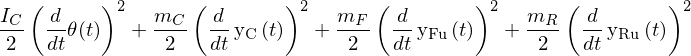

In [4]:
T = (mR/2*yRu.diff(t)**2 +  # unsprung mass motion
     mF/2*yFu.diff(t)**2 +  # unspring mass motion
     mC/2*yC.diff(t)**2 +
     #(theta.diff()**2 * (a**2 + b**2) * sm.sin(theta + sm.atan(b/a))**2 +
     #      (yRs.diff(t) + theta.diff(t)*sm.sqrt(a**2 + b**2)*sm.cos(theta + sm.atan(b/a)))**2) +  # car mass center motion
     IC/2*theta.diff(t)**2)
T.simplify()

### Potential Energy

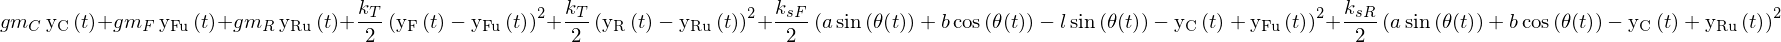

In [5]:
U = (mR*g*yRu + mF*g*yFu + mC*g*yC +   # gravity
     kT/2*(yR-yRu)**2 + kT/2*(yF-yFu)**2 +  # tire stiffness (assume free length = 0)
     ksR/2*(yRu-yRs)**2 + ksF/2*(yFu-yFs)**2)  # suspension stiffness (assumes free length = 0)
U

### Energy Dissipation

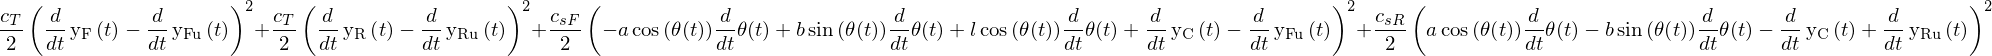

In [6]:
R = (cT/2*(yRu.diff(t)-yR.diff(t))**2 +
     cT/2*(yFu.diff(t)-yF.diff(t))**2 + 
     csR/2*(yRs.diff(t)-yRu.diff(t))**2 +
     csF/2*(yFs.diff(t)-yFu.diff(t))**2)
R.simplify()

In [7]:
def lagrange_eq(T, U, R, coord):
    L = T - U
    return L.diff(coord.diff(t)).diff(t) - L.diff(coord) + R.diff(coord.diff(t))

In [8]:
f_theta = sm.trigsimp(lagrange_eq(T, U, R, theta))

In [9]:
f_theta

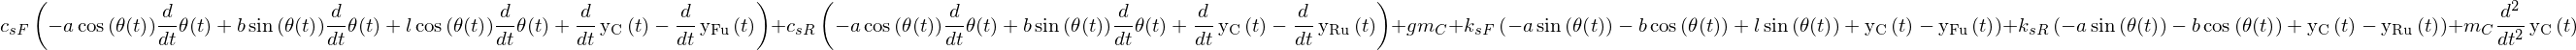

In [10]:
f_yc = sm.trigsimp(lagrange_eq(T, U, R, yC))
f_yc

In [11]:
f_yru = sm.trigsimp(lagrange_eq(T, U, R, yRu))
f_yfu = sm.trigsimp(lagrange_eq(T, U, R, yFu))

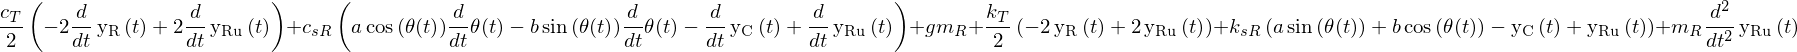

In [12]:
f_yru

In [13]:
f_yfu

In [14]:
f = sm.Matrix([f_theta, f_yc, f_yru, f_yfu])

Check that if no vel and accel, equilbrium is satisfied.

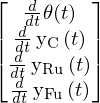

In [15]:
q = sm.Matrix([theta, yC, yRu, yFu])
u = q.diff(t)
u

In [16]:
r = sm.Matrix([yR, yF, yR.diff(t), yF.diff(t)])

In [17]:
f_static = f.subs(dict(zip(u.diff(t), sm.zeros(4, 1)))).subs(dict(zip(u, sm.zeros(4, 1)))).subs(dict(zip(r, sm.zeros(4, 1))))

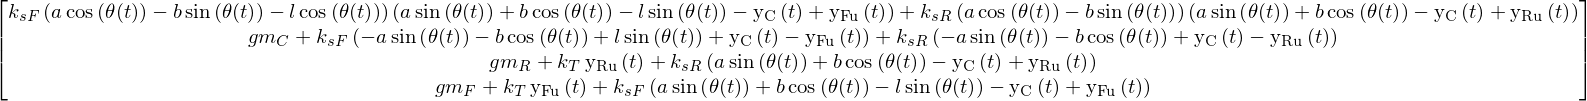

In [18]:
f_static

In [19]:
find_dynamicsymbols(f_static)

NameError: name 'find_dynamicsymbols' is not defined

In [ ]:
f_static.free_symbols

# Put into first order form

Find the linear coefficient matrix for:

$$ \mathbf{M} \dot{\mathbf{u}} = \mathbf{F}$$

In [ ]:
M = f.jacobian(u.diff(t))
M

In [ ]:
F = -(f - M * u.diff(t)).expand()  # expand will cancel some stuff

In [ ]:
udot = M.LUsolve(F)

In [ ]:
udot = udot.subs(dict(zip(u, [omega, vC, vRu, vFu])))

In [ ]:
udot = udot.subs({yF.diff(): vF, yR.diff(): vR})

In [ ]:
udot

In [ ]:
from sympy.physics.mechanics import find_dynamicsymbols

In [ ]:
find_dynamicsymbols(udot)

# Simulate

In [ ]:
eval_omegadot = sm.lambdify((yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                             mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                             yF, yR, vF, vR), udot[0])
eval_vcdot = sm.lambdify((yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                             mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                          yF, yR, vF, vR), udot[1])
eval_vrudot = sm.lambdify((yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                             mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                           yF, yR, vF, vR), udot[2])
eval_vfudot = sm.lambdify((yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                             mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                           yF, yR, vF, vR), udot[3])

In [ ]:
def beam_coeffs(d, Y):
    A = np.array([[d**4, d**3, d],
                  [(d/2)**4, (d/2)**3, d/2],
                  [4*(d/2)**3, 3*(d/2)**2, 1]])
    b = np.array([0, -Y, 0])
    c1, c2, c3 = np.linalg.solve(A, b)
    return c1, c2, c3

a, b, c = beam_coeffs(30, 0.07)

In [ ]:
def rhs(yRu, yFu, yC, theta, vRu, vFu, vC, omega,
        mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF,
        a, b, l, g, v, Y, d, time):
    
    # sinusoidal road
    wb = v / d * 2 * np.pi
    
    yR = Y * np.sin(wb * time)
    yF = Y * np.sin(wb * (time + l / v * np.cos(theta)))
    
    vR = wb * Y * np.cos(wb * time)
    vF = Y * (wb - omega * l / v * np.sin(theta)) * np.cos(wb * (time + l / v * np.cos(theta)))
    
    # beam road
    c1, c2, c3 = beam_coeffs(d, Y)
    xR = (v * time) % d
    yR = c1 * xR**4 + c2 * xR**3 + c3 * xR
    xF = ((v * time) + l * np.cos(theta)) % d
    yF = c1 * xF**4 + c2 * xF**3 + c3 * xF
    
    vR = (4 * c1 * xR**3 + 3 * c2 * xR**2 + c3) * v
    vF = (4 * c1 * xF**4 + 3 * c2 * xF**3 + c3) * (-l / v * np.sin(theta) * omega + v)
    
    # flat road
    #yR = 0
    #yF = 0
    #vR = 0
    #vF = 0
    
    theta_dot = omega
    yc_dot = vC
    yru_dot = vRu
    yfu_dot = vFu
    
    omega_dot = eval_omegadot(yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                                  mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                              yF, yR, vR, vF)
    vc_dot = eval_vcdot(yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                        mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                        yF, yR, vR, vF)
    vru_dot = eval_vrudot(yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                          mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                          yF, yR, vR, vF)
    vfu_dot = eval_vfudot(yRu, yFu, yC, theta, vRu, vFu, vC, omega,
                          mR, mF, mC, IC, kT, cT, ksR, csR, ksF, csF, a, b, l, g,
                          yF, yR, vR, vF)
    return theta_dot, yc_dot, yru_dot, yfu_dot, omega_dot, vc_dot, vru_dot, vfu_dot 

In [ ]:
rhs(*np.random.random(26))

In [ ]:
rhs(0, 0, 0, 0, 0, 0, 0, 0,
    .15*1200/2, .15*1200/2, 1200, 2100, 135000, 1400, 28000, 2000, 21000, 2500, 1.9, 0.6, 2.9, 9.81,
    25, 0.035, 30, 0.0)

In [ ]:
rhs(*np.random.random(8),
    .15*1200/2, .15*1200/2, 1200, 2100, 135000, 1400, 28000, 2000, 21000, 2500, 1.9, 0.6, 2.9, 9.81,
    25, 0.035, 30, 10.0)

In [ ]:
from resonance.nonlinear_systems import MultiDoFNonLinearSystem

In [ ]:
sys = MultiDoFNonLinearSystem()

In [ ]:
sys.constants['mR'] = 0.1 * 1200 / 2  # kg
sys.constants['mF'] =  0.1 * 1200 / 2  # kg
sys.constants['mC'] = 1200  # kg
sys.constants['IC'] = 2100  # kg m**2 
sys.constants['kT'] = 135000  # N/m
sys.constants['cT'] = 1400  # kg s
sys.constants['ksR'] = 21000  #28000  # N/m 
sys.constants['csR'] = 2000  # kg s 
sys.constants['ksF'] = 21000  # N/m
sys.constants['csF'] = 2000  #2500  # kg s
sys.constants['a'] = 1.5  # m
sys.constants['b'] = 0.6  # m 
sys.constants['l'] = 3.0  # m
sys.constants['g'] = 9.81  # m/s**2
sys.constants['v'] = 13  # m/s
sys.constants['Y'] = 0.07  # m
sys.constants['d'] = 30.0  # m

In [ ]:
sys.constants

In [ ]:
sys.coordinates['theta'] = 0.0
sys.coordinates['yC'] = -((sys.constants['mR'] + sys.constants['mF'] + sys.constants['mC']) * sys.constants['g'] /
                          (sys.constants['ksR'] + sys.constants['ksF']))
sys.coordinates['yC'] = 0.271756
sys.coordinates['yRu'] = -((sys.constants['mR'] + sys.constants['mC'] * 
                           sys.constants['a'] / sys.constants['l']) * sys.constants['g'] / sys.constants['kT'])
sys.coordinates['yRu'] = -0.04796
sys.coordinates['yFu'] = -((sys.constants['mF'] + sys.constants['mC'] * 
                           (1 - sys.constants['a'] / sys.constants['l'])) * sys.constants['g'] / sys.constants['kT'])
sys.coordinates['yFu'] = -0.04796
sys.speeds['omega'] = 0
sys.speeds['vC'] = 0
sys.speeds['vRu'] = 0
sys.speeds['vFu'] = 0

In [ ]:
5.48 / 2 / np.pi * 30

In [ ]:
def road_height(v, d, Y, time):
    wb = v / d * 2 * np.pi  # rad /s
    return Y * np.sin(wb * time)

def road_height(v, d, Y, time):
    a, b, c = beam_coeffs(d, Y)
    xR = (v * time) % d
    return a * xR**4 + b * xR**3 + c * xR

#def road_height(v, d, Y, time):
#    return 0

In [ ]:
sys.add_measurement('yR', road_height)

In [ ]:
def road_height_front(v, Y, d, l, theta, time):
    wb = v / d * 2 * np.pi  # rad /s
    return Y * np.sin(wb * (time + l * np.cos(theta) / v)) 

def road_height_front(v, d, Y, l, theta, time):
    a, b, c = beam_coeffs(d, Y)
    xF = ((v * time) + l * np.cos(theta)) % d
    return a * xF**4 + b * xF**3 + c * xF

#def road_height_front(v, d, Y, l, theta, yR, time):
#    return 0

sys.add_measurement('yF', road_height_front)

In [ ]:
def rear_suspension_height(yC, theta, a, b):
    return yC - a*np.sin(theta) - b*np.cos(theta)

sys.add_measurement('yRs', rear_suspension_height)

def front_suspension_height(yC, theta, a, b, l):
    return yC -a*np.sin(theta) - b*np.cos(theta) + l * np.sin(theta)

sys.add_measurement('yFs', front_suspension_height)

In [ ]:
def theta_deg(theta):
    return np.rad2deg(theta)

sys.add_measurement('theta_deg', theta_deg)

In [ ]:
sys.measurements

In [ ]:
sys.diff_eq_func = rhs

In [ ]:
import resonance

In [ ]:
traj = sys.free_response(30)

In [ ]:
traj

In [ ]:
traj[['theta_deg', 'yC', 'yRu', 'yFu', 'yR', 'yF']].plot(subplots=True);

# Animation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse

view_width = 10
wheel_diameter = 0.6


def plot_config(yC, theta, yRs, yFs, yRu, yFu, yR, yF, a, b, l, time):

    fig, ax = plt.subplots(1, 1)

    ax.set_ylim((-1.0, 3.0))
    ax.set_ylabel('Height [m]')
    ax.set_aspect('equal')

    lat_pos = 0  # m
    y_offset = 0 * b


    lat = np.linspace(lat_pos - view_width / 3,
                      lat_pos + 2 * view_width / 2,
                      num=100)

    ax.set_xlim((lat[0], lat[-1]))

    rect = Rectangle(
                     (0, yRs + y_offset),  # (x,y)
                      l,  # width
                      b * 2,  # height
                     angle=np.rad2deg(theta))
    
    front_wheel = Ellipse((lat_pos + l * np.cos(theta), yF + wheel_diameter/2 - yFu),
                          wheel_diameter,
                          wheel_diameter + yFu, color='red')
    
    rear_wheel = Ellipse((lat_pos, yR + wheel_diameter/2 - yRu),
                         wheel_diameter,
                         wheel_diameter + yRu, color='red')

    ax.add_patch(rect)
    ax.add_patch(front_wheel)
    ax.add_patch(rear_wheel)

    time_txt = ax.text(lat_pos - 2.0, 0.5, 'Time: {:1.1f} s'.format(time))

    # NOTE: Just plot a flat road for now because there may be no
    # results available
    road = ax.plot(lat, np.zeros_like(lat), color='black')[0]

    rear_suspension = ax.plot([lat_pos, lat_pos],
                              [yR + wheel_diameter/2, yRs + y_offset + b],
                              linewidth='4', marker='o', color='yellow')[0]
    front_suspension = ax.plot([lat_pos + l * np.cos(theta), lat_pos + l * np.cos(theta)],
                              [yF + wheel_diameter/2, yFs + y_offset + b],
                              linewidth='4', marker='o', color='yellow')[0]

    return fig, ax, rect, road, rear_suspension, front_suspension, rear_wheel, front_wheel, time_txt

sys.config_plot_func = plot_config

In [ ]:
fig, ax, rect, road, rear_suspension, front_suspension, rear_wheel, front_wheel, time_txt = sys.plot_configuration();

In [ ]:
def plot_update(v, yC, theta, yRs, yFs, yRu, yFu, a, b, l,
                time, time__hist, time__futr,
                yR, yR__hist, yR__futr,
                yF,
                ax, rect, road, rear_suspension, front_suspension, rear_wheel, front_wheel, time_txt):
    
    y_offset = 2 * b
    
    lat_pos = v * time

    time_txt.set_text('Time: {:1.1f} s'.format(time))
    time_txt.set_position((lat_pos - 2.0, 0.5))

    ax.set_xlim((lat_pos - view_width / 3, lat_pos + 2 * view_width / 3))

    rect.set_xy([lat_pos, yRs + y_offset])    
    rect.angle = np.rad2deg(theta)

    lat = v * np.hstack((time__hist, time__futr))

    road.set_xdata(lat)
    road.set_ydata(np.hstack((yR__hist, yR__futr)))

    rear_suspension.set_xdata([lat_pos, lat_pos])
    rear_suspension.set_ydata([yR +  wheel_diameter/2 + yRu, yRs + y_offset])
    
    front_suspension.set_xdata([lat_pos + l * np.cos(theta), lat_pos + l * np.cos(theta)])
    front_suspension.set_ydata([yF + wheel_diameter/2 + yFu, yFs + y_offset])
    
    front_wheel.center = (lat_pos + l * np.cos(theta), yF + wheel_diameter/2 + yFu)
    front_wheel.height = wheel_diameter + 2 * yFu
    
    rear_wheel.center = (lat_pos, yR + wheel_diameter/2 + yRu)
    rear_wheel.height = wheel_diameter + 2 * yRu


sys.config_plot_update_func = plot_update

In [ ]:
plot_update(1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
            1, np.arange(5), np.arange(5),
            2, np.arange(5), np.arange(5),
            3,
            ax, rect, road, rear_suspension, front_suspension, rear_wheel, front_wheel, time_txt)

In [ ]:
sys.animate_configuration()

# Linear Model

In [ ]:
q = sm.Matrix([theta, yC, yRu, yFu])
u = sm.Matrix([theta.diff(t), yC.diff(t), yRu.diff(t), yFu.diff(t)])
x = sm.Matrix([theta, yC, yRu, yFu, theta.diff(t),
               yC.diff(t), yRu.diff(t), yFu.diff(t),
               theta.diff(t, 2), yC.diff(t, 2), yRu.diff(t, 2), yFu.diff(t, 2)])
x

x0 = sm.zeros(12, 1)
x0

f_lin = f.subs(dict(zip(x, x0))) + f.jacobian(x).subs(dict(zip(x, x0))) * (x - x0)
f_lin

In [ ]:
M = f_lin.jacobian(u.diff(t))
str(M)

In [ ]:
C = f_lin.jacobian(u)
str(C)

In [ ]:
K = f_lin.jacobian(q)
str(K)

In [ ]:
F = - f.subs(dict(zip(x, x0)))
F